> Created on Mon Jan 25 09:22:04 2021 @author: Richie Bao-caDesign设计(cadesign.cn)__+updated on Tue Jan 11 12:00:12 2022 by Richie Bao 

## 2.6.6 高分辨率遥感影像解译

### 2.6.6.1 无监督土地分类(聚类方法)

遥感影像的各个波段记录了地物的相关信息，那么以波段的数据作为机器学习的训练数据集，喂入相关模型，可以对应解决相关问题。其中之一为使用聚类的方法初步实现无监督土地分类（K-Menas算法）。sentinel-2影像有多个波段，可以尝试使用单个波段，或者多个波段作为特征向量，对比波段的合成显示，估计不同输入数据聚类结果的效果。

sentinel-2影像的信息均记录于'MTD_MSIL2A.xml'中（需要查看sentinel-2部分内容），因此可以从该文件获取各个波段的路径。该文件给出的路径为相对于影像文件夹的相对路径。

In [1]:
def Sentinel2_bandFNs(MTD_MSIL2A_fn):
    import xml.etree.ElementTree as ET
    '''
    funciton - 获取sentinel-2波段文件路径，和打印主要信息
    
    Paras:
        MTD_MSIL2A_fn - MTD_MSIL2A 文件路径
    
    Returns:
        band_fns_list - 波段相对路径列表
        band_fns_dict - 波段路径为值，反应波段信息的字段为键的字典
    '''
    Sentinel2_tree=ET.parse(MTD_MSIL2A_fn)
    Sentinel2_root=Sentinel2_tree.getroot()

    print("GENERATION_TIME:{}\nPRODUCT_TYPE:{}\nPROCESSING_LEVEL:{}".format(Sentinel2_root[0][0].find('GENERATION_TIME').text,
                                                           Sentinel2_root[0][0].find('PRODUCT_TYPE').text,                 
                                                           Sentinel2_root[0][0].find('PROCESSING_LEVEL').text
                                                          ))
    
    print("MTD_MSIL2A.xml 文件父结构:")
    for child in Sentinel2_root:
        print(child.tag,"-",child.attrib)
    print("_"*50)    
    band_fns_list=[elem.text for elem in Sentinel2_root.iter('IMAGE_FILE')] #[elem.text for elem in Sentinel2_root[0][0][11][0][0].iter()]
    band_fns_dict={f.split('_')[-2]+'_'+f.split('_')[-1]:f+'.jp2' for f in band_fns_list}
    print('获取sentinel-2波段文件路径:\n',band_fns_dict)
    
    return band_fns_list,band_fns_dict
    
MTD_MSIL2A_fn=r'G:\data\S2B_MSIL2A_20200709T163839_N0214_R126_T16TDM_20200709T211044.SAFE\MTD_MSIL2A.xml'
band_fns_list,band_fns_dict=Sentinel2_bandFNs(MTD_MSIL2A_fn)

GENERATION_TIME:2020-07-09T21:10:44.000000Z
PRODUCT_TYPE:S2MSI2A
PROCESSING_LEVEL:Level-2A
MTD_MSIL2A.xml 文件父结构:
{https://psd-14.sentinel2.eo.esa.int/PSD/User_Product_Level-2A.xsd}General_Info - {}
{https://psd-14.sentinel2.eo.esa.int/PSD/User_Product_Level-2A.xsd}Geometric_Info - {}
{https://psd-14.sentinel2.eo.esa.int/PSD/User_Product_Level-2A.xsd}Auxiliary_Data_Info - {}
{https://psd-14.sentinel2.eo.esa.int/PSD/User_Product_Level-2A.xsd}Quality_Indicators_Info - {}
__________________________________________________
获取sentinel-2波段文件路径:
 {'B02_10m': 'GRANULE/L2A_T16TDM_A017455_20200709T164859/IMG_DATA/R10m/T16TDM_20200709T163839_B02_10m.jp2', 'B03_10m': 'GRANULE/L2A_T16TDM_A017455_20200709T164859/IMG_DATA/R10m/T16TDM_20200709T163839_B03_10m.jp2', 'B04_10m': 'GRANULE/L2A_T16TDM_A017455_20200709T164859/IMG_DATA/R10m/T16TDM_20200709T163839_B04_10m.jp2', 'B08_10m': 'GRANULE/L2A_T16TDM_A017455_20200709T164859/IMG_DATA/R10m/T16TDM_20200709T163839_B08_10m.jp2', 'TCI_10m': 'GRANULE/L2A_T16TDM

根据返回字典的键，可以提取对应的波段路径名。'earthpy'库的`es.stack`方法可以融合多个波段，同时会返回波段额元数据，包括：'driver'驱动，'dtype'数据类型，'nodata'空值，'width'影像宽度，'height'影像高度，'count'波段数量，'crs'坐标系统（投影），'transform'变换，'blockxsize'x向单元数量（每个单元的精度为10m，即一个像素代表10m的实际地理空间，小于10m的地物则无法分辨），'blockysize'y向单元数量。

meta_data:
 {'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4700040.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


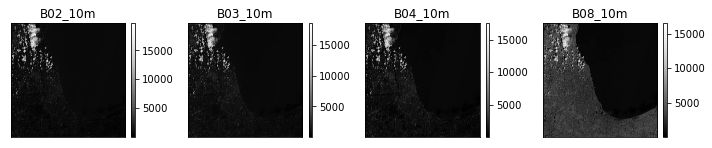

In [2]:
import os
import matplotlib.pyplot as plt
import earthpy.spatial as es
import earthpy.plot as ep
import geopandas as gpd

imgs_root=r"G:\data\S2B_MSIL2A_20200709T163839_N0214_R126_T16TDM_20200709T211044.SAFE"
bands_selection=["B02_10m","B03_10m","B04_10m","B08_10m"]
stack_bands=[os.path.join(imgs_root,band_fns_dict[b]) for b in bands_selection]
array_stack, meta_data=es.stack(stack_bands)
print("meta_data:\n",meta_data)

ep.plot_bands(array_stack,title=bands_selection,cols=array_stack.shape[0],cbar=True,figsize=(10,10))
plt.show()

在QGIS中读取一个波段，或多个波段的组合显示，绘制裁切边界（设置坐标为WGS84，不配置投影，读取后根据影像的投影再进行定义），用于影像的裁切。裁切文件保存用于指定的文件夹下。

In [3]:
crop_output_dir=r'G:\data\data_processed\sentinel-2_crop'
imgs_crs=meta_data['crs']

shape_polygon_fp='./data/sentinel2Chicago_boundary/sentinel2Chicago_boundary.shp'
crop_bound=gpd.read_file(shape_polygon_fp)
crop_bound_proj=crop_bound.to_crs(imgs_crs)

crop_imgs=es.crop_all([os.path.join(imgs_root,f+'.jp2') for f in band_fns_list], crop_output_dir, crop_bound_proj, overwrite=True) #对所有波段band执行裁切
print("finished cropping...")

finished cropping...


显示裁切后的影像。

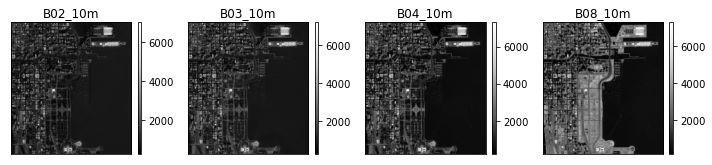

In [4]:
import glob
croppedImgs_fns=glob.glob(crop_output_dir+"/*.jp2")
croppedBands_fnsDict={f.split('_')[-3]+'_'+f.split('_')[-2]:f for f in croppedImgs_fns}

bands_selection_=["B02_10m","B03_10m","B04_10m","B08_10m"]  #,"AOT_10m","WVP_10m"
cropped_stack_bands=[croppedBands_fnsDict[b] for b in bands_selection_]

cropped_array_stack,_=es.stack(cropped_stack_bands)
ep.plot_bands(cropped_array_stack,title=bands_selection_,cols=cropped_array_stack.shape[0],cbar=True,figsize=(10,10))
plt.show()

可以尝试调整不同的聚类数量`n_cluster`参数，分类越多划分的地物类别也就越细。基于聚类无监督分类的结果并没有明确分类的名称，需要结合已经聚类的结果，根据实际地物情况判别。注意喂入模型数据的形状为(样本数，特征数)。如果理解为矩阵，则每一列为一个特征向量，每一行为一个样本的多个特征值。通常所输入的特征数越多，即波段数越多，分类的精度越好。

[[2972 3248 3344 3550]
 [2574 2548 2602 2768]
 [1406 1406 1824 1920]
 ...
 [ 825  749  519  484]
 [ 811  738  516  498]
 [ 776  760  538  488]]


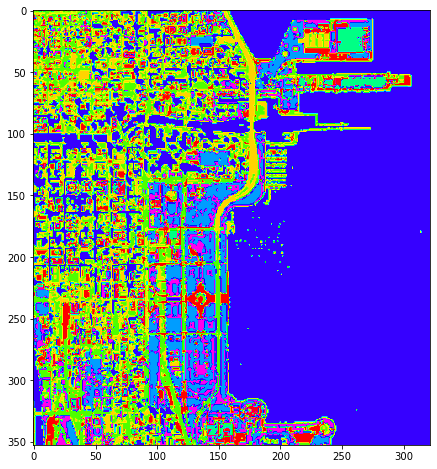

In [5]:
from sklearn import cluster
import matplotlib.pyplot as plt

X=cropped_array_stack.reshape(cropped_array_stack.shape[0],-1).transpose(1,0)
print(X)

k_means=cluster.KMeans(n_clusters=8)
k_means.fit(X)
X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(cropped_array_stack[0,:,:].shape)

plt.figure(figsize=(8,8))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

### 2.6.6.2 VGG16卷积神经网络

[VGGNet](https://arxiv.org/abs/1409.1556)研究了在大规模图像识别环境下，卷积网络深度对识别精度的影响。主要贡献是使用非常小的($3 \times 3$)卷积滤波器(卷积核)和($2 \times 2$)的最大池化层反复堆叠，在深度不断增加的网络下的表现评估。当将网络深度推进到16-19个全支持层时（图表的第C、D列为16层，第E列为19层），可以发现识别精度得以显著提升。该项研究最初用于[ImageNet](http://www.image-net.org/)数据集，并同时能够很好的泛化到其它数据集。

对VGGNet网络的理解同样可以对应到图像特征提取-尺度不变特征转换下尺度空间(scale space)的概念上。因为不同的地物尺寸不同，因此对于同一地理范围下的影像，分辨率越高，例如0.3-05m，则可以识别出行人轮廓。但是10m的高空分辨率则无法识别，而对于通常大于10m的对象，例如建筑，绿地则可以识别。这个变换的分辨率就是尺度空间的纵向深度，由降采样实现。对应到VGG网络上，就是网络深度的不断增加，是由'maxpool'最大池化层实现。因为不同地物的尺寸多样，但是通常可以形成一个连续的尺寸变化，例如从室外摆放的餐具，过往或静坐的行人，到车辆，建筑，再到农田和成片的林地。因此为了检测到每一地物对应的尺度空间，采用$2 \times 2$的最大池化能够很好的捕捉到不同的地物。即低分辨率的图像可以忽略掉较小的对象，而专注于该尺度及之上的对象，以此类推。在尺度空间中还有一个水平向，使用不同的卷积核检测同一尺度即深度下地物即图像的特征。不同的卷积核会识别出不同的特征内容，例如对象间的边界形状，颜色的差异变化，以及很多一般常识很难判定但却可以区分对象的特征。因此在每一深度进行卷积操作时，通常要使用多个不同的卷积核，并随机初始化卷积核数值，以捕捉到对象的特征。这对应到深度网络结构中的输出通道数。VGGNet在深度增加过程中，所使用的卷积核大小不变，均为$3 \times 3$。因为深度的逐层增加，不同尺度的地物会被捕捉到，同一大小的卷积核可以检测到不同地物的特征。同时，使用的卷积数量在增加，以适应深度增加，尺度增大，即图像越加模糊时的特征提取。图像的特征并不仅表现在一次卷积的结果上，例如如果应用一次卷积提取了对象的轮廓边界，那么仍然可以再应用卷积提取对象轮廓边界的特征，以此类推。这可以用于解释每一层深度/尺度下使用多层卷积的原因。

<a href=""><img src="./imgs/2_6_6_01.png" height='auto' width='600' title="caDesign"></a>

将上述表格的第D列，即VGG16，通过方块序列图的形式可以更好的表述，观察层级间的变化。

<a href=""><img src="./imgs/2_6_6_02.png" height='auto' width='1000' title="caDesign"></a>

* [ImageNet数据集](http://www.image-net.org/)

ImageNet数据集于2007年开始建设，已有超过1500万张图像，2万多个类别，是一个庞大的数据集。是根据[WordNet](https://wordnet.princeton.edu/)层次结构(目前只有名词nouns)组织的图像数据库。其中层次结构的每一个节点都由成百上千张图像描述。ImageNet数据集1000个类别文件可以从[imagenet_classes.txt](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt)处下载，其分类涉及动植物，各类人造物。

VGGNet预训练模型已经置于[torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html)模型库中，通过下载该模型，来尝试识别对象。参考[VGG-NETS](https://pytorch.org/hub/pytorch_vision_vgg/)

> 参考文献：
1. Karen Simonyan∗ & Andrew Zisserman+.[VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION](https://arxiv.org/abs/1409.1556)[J].Published as a conference paper at ICLR 2015.arXiv:1409.1556v6[cs.CV] 10 Apr 2015
2. [VGG-NETS](https://pytorch.org/hub/pytorch_vision_vgg/)

* 01-下载预训练的VGG16模型

In [6]:
import torch
model=torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\richi/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\richi/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

* 02-读取一幅图像。执行调整图像大小Resize、裁切CenterCrop、转换为张量ToTensor和标准化Normalize等操作，使其满足网络结构的数据输入需求。

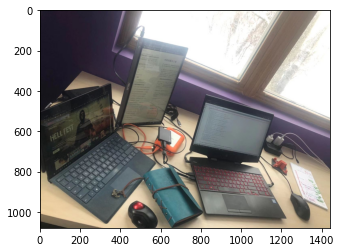

In [7]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

cat_01=r'./data/stuff_01.jpg' #cat_01.png;stuff_01.jpg
cat_img=Image.open(cat_01).convert('RGB')
plt.imshow(cat_img)
plt.show()

In [8]:
input_image=Image.open(cat_01)
preprocess=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor=preprocess(input_image)
input_batch=input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
print("VGG16输入数据的形状（batchsize, nChannels, Height, Width）：",input_batch.shape)

VGG16输入数据的形状（batchsize, nChannels, Height, Width）： torch.Size([1, 3, 224, 224])


* 03 - 图像中的内容预测概率

In [9]:
#输入数据和模型传入GPU执行运输 move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch=input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output=model(input_batch)
#全连接最后一层的线性输出通道数为1000，对应ImageNet数据集的1000个分类 Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities= torch.nn.functional.softmax(output[0], dim=0)
print("预测的1000个分类联合概率分布数组的形状：",probabilities.shape)

预测的1000个分类联合概率分布数组的形状： torch.Size([1000])


* 04 - 打印预测概率分布中最大的前几个对象，可以观察到预测的对象，desktop computer(及monitor,laptop,screen,computer keyboard),notebook、desk,都出现在该图像中。而printer和modem则没有，但是modem和插座的形状比较近似。

In [10]:
# Read the categories ImageNet数据集1000个类别文件可以从[imagenet_classes.txt](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt)处下载
with open("./data/imagenet_classes.txt", "r") as f:
    categories=[s.strip() for s in f.readlines()]
#显示所预测图像，前几个最大概率对应的分类名 Show top categories per image
top5_prob,top5_catid=torch.topk(probabilities, 10)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

desktop computer 0.17022140324115753
notebook 0.15083454549312592
desk 0.14025698602199554
monitor 0.1317901611328125
laptop 0.10974671691656113
mouse 0.10374213010072708
screen 0.07918370515108109
computer keyboard 0.033995289355516434
printer 0.021042412146925926
modem 0.008885478600859642


### 2.6.6.3 SegNet遥感影像语义分割/解译

SegNet于2016年提出，核心的概念是将网络划分为encoder编码器网络，decoder解码器网络，和一个像素级的分类层(SoftMax)。编码器网络结构与VGG16的13个特征提取卷积层结构相同。而解码器网络的结构与编码器网络刚好相逆，可以理解为反卷积的过程，每个编码器层都对应一个解码器层，将编码结果的低分辨率特征重新映射到输入时的分辨率，以便进行像素级分类，为每个像素生成类概率，输出不同分类的最大值，得到图像分割图。编码过程是池化层（`nn.MaxPool2d(2, return_indices=True)`）下采样的过程，而解码过程是提取的特征值上采样(`nn.MaxUnpool2d(2)`)的过程。*SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation*一文给出的SegNet网络结构图，非常清晰的解释了这一过程。

<a href=""><img src="./imgs/2_6_6_03.png" height='auto' width='500' title="caDesign"></a>

下采样(pooling)就是池化层的作用，增加网络的深度。对于最大池化层，是提取区域内最大值作为输出，那么就可以得到最大值所在位置的索引。因此在上采样(upsampling)的过程中，对于$2 \times 2$池化下采样结果执行上采样时，已经丢失3个权重值，在将特征图放大2倍后，原来特征图的数据会根据下采样时获取的位置索引归位放入。对于池化最大值位置索引，PyTorch的`nn.MaxPool2d()`下`return_indices=True`参数配置可以返回索引值。

<a href=""><img src="./imgs/2_6_6_04.png" height='auto' width='300' title="caDesign"></a>

> 参考文献
1. Vijay Badrinarayanan, Alex Kendall, Roberto Cipolla, Senior Member, IEEE. SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation[J].arXiv:1511.00561v3 [cs.CV] 10 Oct 2016
2. [Deep learning for Earth Observation](https://github.com/nshaud/DeepNetsForEO)(代码迁移地址)

* nn.MaxPool2d(2, return_indices=True)

下述代码片段展示了编码器最大池化，及解码器应用索引值上采样的过程。

In [12]:
import torch.nn as nn
pool=nn.MaxPool2d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2)
input = torch.tensor([[[[ 0.,  1,  2,  3],
                        [ 4,  5,  6,  7],
                        [ 8, 9, 10, 11],
                        [12, 13, 14, 15]]]])

output, indices=pool(input)
print("最大池化索引：\n",indices)
print("最大池化结果：\n",output)

upsampling=unpool(output, indices)
print("根据池化索引上采样结果：\n",upsampling)

最大池化索引：
 tensor([[[[ 5,  7],
          [13, 15]]]])
最大池化结果：
 tensor([[[[ 5.,  7.],
          [13., 15.]]]])
根据池化索引上采样结果：
 tensor([[[[ 0.,  0.,  0.,  0.],
          [ 0.,  5.,  0.,  7.],
          [ 0.,  0.,  0.,  0.],
          [ 0., 13.,  0., 15.]]]])


* 01-调入所用的库

In [13]:
#imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
import os

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

*  02 - [ISPRS dataset](https://www2.isprs.org/commissions/comm2/wg4/benchmark/data-request-form/)数据集，及数据查看，预处理，和小批量可迭代数据加载

[ISPRS](https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-vaihingen/)是遥感图像数据集。对于遥感图像数据集，因为大量影像的开源和图像解译工具的存在（例如e-Cognition），可以用传统的解译工具建立影像的分割标签，从而建立数据集。因此目前有大量的遥感影像数据集可以使用，避免自行从新建立。下载的ISPRS数据集，包括三个地方分别为Potsdam,Toronto和Vaihingen。每个对应区域的所有数据放置于以地名命名的文件夹下，包含.tif格式（GTiff驱动），投影为CRS-->EPSG:32633 - WGS 84 / UTM zone ?N - Projected的原始影像，以及影像标签，标签类别包括"roads", "buildings", "low veg.", "trees", "cars", "clutter"，可以分辨出主要的地物内容。如果该数据集的标签不能满足解译后使用上的需求，可以用其它满足要求的影像数据集替换，或者用传统工具自行解译部分影像用作训练数据集。数据有blue,green,red和NIR四个波段，不过波段已经合成为RGB,IRRG,RGBIR等形式，通常放置于各自单独的文件夹下。下述训练的数据使用的为IRRG合成的波段，即NIR+red+green。Vaihingen区域数据是由德国摄影测量和遥感协会(German Association of Photogrammetry and Remote Sensing,DGPF)用于测试数字航拍数据的子集。图像为8cm地面分辨率。

建立数据存放的字符串格式化模式，在后续调用`class ISPRS_dataset(torch.utils.data.Dataset)`时使用。将训练集的数据对应到DATA_FOLDE文件夹下，训练集的标签对应到LABEL_FOLDER文件夹下，测试集的数据对应到ERODED_FOLDER文件夹下。

In [31]:
# Parameters
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
FOLDER = r"G:/data/ISPRS/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 10 # Number of samples in a mini-batch 10

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'Vaihingen'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    # Uncomment the next line for IRRG data
    # DATA_FOLDER = MAIN_FOLDER + '3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    # For RGB data
    DATA_FOLDER = MAIN_FOLDER + '2_Ortho_RGB/top_potsdam_{}_RGB.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'

数据查看，包括影像和对应标签。定义的函数` convert_to_color(arr_2d, palette=palette)`和`convert_from_color(arr_3d, palette=invert_palette)`给定数值和对应RGB颜色值映射字典，实现数值和颜色之间的互相转换。

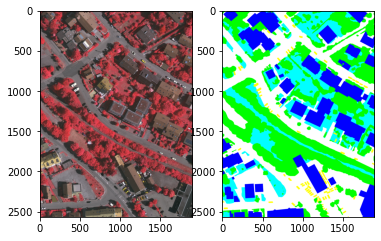

Ground truth in numerical format has shape (2566,1893) : 
 [[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


In [16]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """数值标签转换为RGB颜色标签 Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """RGB颜色标签转换为数值标签（灰度图） RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread(r'G:\data\ISPRS\Vaihingen\top/top_mosaic_09cm_area11.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread(r'G:\data\ISPRS\Vaihingen\gts_for_participants/top_mosaic_09cm_area11.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

定义小批量可迭代数据加载类，同时执行图像增广(image augmentation)，由定义的`data_augmentation`函数执行随机的翻转和镜像；并标准化数据到[0,1]。同时标识`data_augmentation`函数有`@classmethod`装饰器，即标记该方法为类方法的装饰器。除了由实例对象调用外，可以直接由该类调用。如果作为父类，其子类也可以直接调用父类的类方法。

In [20]:
class C:
    @classmethod
    def f(cls,arg_str):
        print(cls,arg_str)
class C_child(C):
    pass
print(C.f("类对象调用类方法..."))
c=C()
print(c.f("类实例调用类方法..."))
print(C_child.f("子类调用父类的类方法..."))

<class '__main__.C'> 类对象调用类方法...
None
<class '__main__.C'> 类实例调用类方法...
None
<class '__main__.C_child'> 子类调用父类的类方法...
None


In [21]:
def get_random_pos(img, window_shape):
    """给定窗口大小，随机提取部分图像 Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

# Dataset class
class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

加载数据。并切分数据集为训练和测试数据集。

In [34]:
# Load the datasets
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["".join(f.split('')[5:7]) for f in all_files]
elif DATASET == 'Vaihingen':    
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
# Random tile numbers for train/test split
train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
test_ids = list(set(all_ids) - set(train_ids))
print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['17', '28', '32', '34', '26', '15', '7', '21', '30', '23', '3']
Tiles for testing :  ['13', '37', '5', '1', '11']


* 03 - 定义网络

In [35]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        #-------------------------------------------------------------
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        #-------------------------------------------------------------
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x

从地址 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth' 下载VGG16网络模型预训练参数。因为下载的预训练参数对应的层名与上述模型定义的不同，因此需要一一对位，将权值映射到新的层名上来。然后应用`net.state_dict().update(mapped_weights)`方法更新权值。

In [36]:
# instantiate the network
net = SegNet()

In [38]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile(r'G:\data\model\vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, r'G:\data\model\vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load(r'G:\data\model\vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.state_dict().update(mapped_weights)
    print("_"*50)
    print("Loaded VGG-16 weights in SegNet !")
except:
    print("Ignore missing keys")
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

In [39]:
if torch.cuda.is_available():
    net.to('cuda')

* 04 - 定义训练模型相关函数，损失函数，预测精度及相关度量值（全局精度，F1分数和kappa系数）等内容。

In [68]:
def CrossEntropy2d(input, target, weight=None, size_average=True):
    """定义损失函数——2D版交叉熵损失 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    '''定义预测精度'''
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """给定步幅，窗口形状，滑动过整幅图像，迭代计算窗口所在图像x,y位置值，返回每一切分图像(patch)的x,y坐标值和高宽大小，即yield返回值。参数step可以控制切分窗口叠合的程度 Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """计算图像滑动给定窗口大小的数量 Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    '''预测值度量'''
    cm = confusion_matrix(
            gts,
            predictions,
            labels=range(len(label_values)))  
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    #全局精度 Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    #F1分数 Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    #计算kappa系数 Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

使用标准的随机梯度下降算法优化网络的权值。如果调入了预先训练的VGG16模型参数，则可调整学习率。即encoder编码部分（VGG16卷积，特征提取部分）的训练速度为decoder解码器的一半。

In [41]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

* 05 - 定义测试函数，显示RGB影像，及对应的真实值，及预测值图像。计算`metrics`函数定义的相关预测度量值。

In [63]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)
  
        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

* 06 - 定义训练函数。输出损失曲线，显示RGB影像，及对应的真实值，及预测值图像。打印损失值和精度值，观察模型训练情况。同时指定文件夹，保存模型参数。

In [76]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5): 
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            #print("_"*50)
            #print(iter_)
            #print(loss.data.item())
            losses[iter_] = loss.data.item()#losses[iter_] = loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data.item(), accuracy(pred, gt)))  #100. * batch_idx / len(train_loader), loss.data[0], accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
        if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            torch.save(net.state_dict(), './model/segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './model/segnet_final')  

* 07 - 训练模型

In [77]:
train(net, optimizer, 10, scheduler) #50

Confusion matrix :
[[1353141   32015   65375   19629    4922    1733]
 [  34820  796320    9073    3273     670       3]
 [  45405   13111  541334   98071      62       0]
 [   9127    2476   85643 1235041      45       0]
 [   9981     742     776     581   32381     214]
 [      0       0       0       0       0       0]]
---
4395964 pixels processed
Total accuracy : 90.0420704082199%
---
F1Score :
roads: 0.9238699220186195
buildings: 0.9430473175696921
low veg.: 0.7732326608502883
trees: 0.9186125171862234
cars: 0.7825750709926893
clutter: 0.0
---
Kappa: 0.8641704967438216
Confusion matrix :
[[5943500  251376  192249   59281   23200    3986]
 [ 257402 6629996   54712    9507    3639      72]
 [ 370167  111835 4206096  564403     529    3257]
 [  59915   12051  533183 4003598     151       0]
 [  45805    6880    1743     828  110866     883]
 [      0       0       0       0       0       0]]
---
23461110 pixels processed
Total accuracy : 89.05825853934446%
---
F1Score :
roads: 0.90

* 08 - 加载保存的SegNet模型参数，应用测试数据集测试模型。通过配置stride参数，设置图像被切分为多个小块之间的重叠程度。重叠程度由stride参数和WINDOW_SIZE=(256, 256)参数（即patch大小）确定。

注意，在应用所训练的模型解译新的图像时，新图像的形式应该与训练数据的形式保持一致或近似，这样才能够保证正确的预测结果。例如图像的高空分辨率，以及波段合成信息能够基本相同。

In [78]:
net.load_state_dict(torch.load('./model/segnet_final'))
if torch.cuda.is_available():
    net.to('cuda')

In [79]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32)

Confusion matrix :
[[1370081   25031   57259   19254    4022    1168]
 [  29015  804242    7865    2584     453       0]
 [  47582   10867  542282   97228      24       0]
 [   7684    2311   72972 1249350      15       0]
 [  10697     260     726     528   32321     143]
 [      0       0       0       0       0       0]]
---
4395964 pixels processed
Total accuracy : 90.95333810740944%
---
F1Score :
roads: 0.9314341810696175
buildings: 0.9535316888675476
low veg.: 0.7864362436887593
trees: 0.9250072928497495
cars: 0.7930560667402773
clutter: 0.0
---
Kappa: 0.8764381914078332
Confusion matrix :
[[6007256  209282  180520   56386   18409    1739]
 [ 201880 6694014   48209    8352    2772     101]
 [ 366170   98613 4254461  535807     385     851]
 [  53371   10865  501938 4042672      52       0]
 [  49247    4373    1509     899  110263     714]
 [      0       0       0       0       0       0]]
---
23461110 pixels processed
Total accuracy : 89.97300639228067%
---
F1Score :
roads: 0.9

* 09 - 显示与保存预测的图像分割/解译

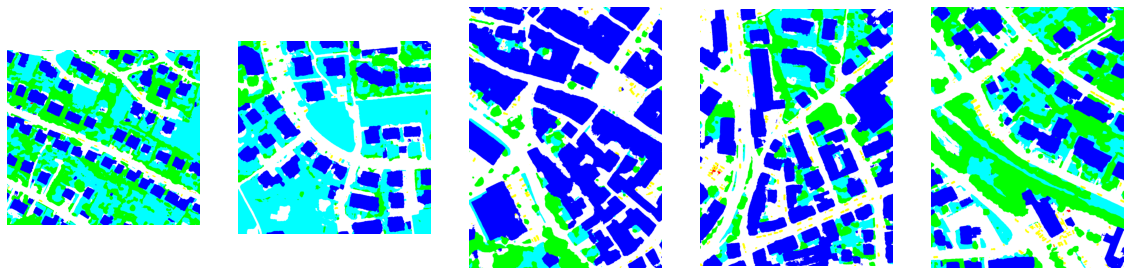

In [81]:
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.figure(figsize=(20,5))

i=0
for p, id_ in tqdm(zip(all_preds,test_ids),total=len(all_preds),leave=False):
    img = convert_to_color(p)
    plt.subplot(1,len(all_preds),i+1)
    plt.imshow(img)
    plt.axis('off')
    
    io.imsave('./results/segment_pred/inference_tile_{}.png'.format(id_), img)
    i+=1
plt.show()

> 可以尝试在DUC(Dense Upsampling Convolution)图像分割部分，用SegNet模型替换DUC实现。